Test out B-mode delensing limit
=======================================================
ToDo:
	* how sensative is the algorithm to knowing the wrong r value. 
	* Is it possible to make the B-mode exactly zero with both stream and potential lensing 
	* very sensative to lmax on E, B. Could this be due to the taylor expansion...
	* update r with a gradient step
	* Program the Hamiltonian sampler of ϕinv and ψinv, with known r.
	* What is the role of the determinant term.

## Load modules, paths and functions

In [25]:
# seed = Uint32[1461298913,3804461922,1461874617,4101139687]
# srand(seed)

#simdir   =  "/Users/ethananderes/Dropbox/BLimit/simulations_$(seed[1])/" # contains the simulation
srcpath  =  "/Users/ethananderes/Dropbox/BLimit/src/"
savepath =  "/Users/ethananderes/Dropbox/BLimit/paper/"

include(srcpath * "Interp.jl")
include(srcpath * "fft.jl")
include(srcpath * "funcs.jl")
using PyPlot, Interp

## parameters of the simulation run

In [26]:
const streammultiplier  = 0.01  # change this eventually
const pixel_size_arcmin = 1.0
const beamFWHM = 2.0
const n = 2^10
const nugget_at_each_pixel = (4.0)^2

16.0

## Grid generation

In [27]:
const d = 2
const deltx   = pixel_size_arcmin * pi / (180 * 60) #this is in radians
const period  = deltx * n
const deltk   = 2π / period  
const dk      = deltk ^ d
const dx      = deltx ^ d
const nyq     = 2π / (2deltx)
const x, y    = meshgrid([0:n-1] * deltx, [0:n-1] * deltx)
const k1, k2  = linspace(-nyq, nyq-deltk, int(n))  |> fftshift |> x->meshgrid(x,x)
const magk    = √(k1.^2 .+ k2.^2)
const φ2_l    = 2.0 * angle(k1 + im * k2)

1024x1024 Array{Float64,2}:
  0.0       0.0       0.0        0.0       …   6.28319   6.28319   6.28319
  3.14159   1.5708    0.927295   0.643501      5.63968   5.35589   4.71239
  3.14159   2.2143    1.5708     1.17601       5.10718   4.71239   4.06889
  3.14159   2.49809   1.96559    1.5708        4.71239   4.3176    3.78509
  3.14159   2.65164   2.2143     1.85459       4.42859   4.06889   3.63155
  3.14159   2.7468    2.38058    2.06075   …   4.22243   3.90261   3.53638
  3.14159   2.8113    2.49809    2.2143        4.06889   3.78509   3.47189
  3.14159   2.8578    2.58499    2.33181       3.95138   3.69819   3.42539
  3.14159   2.89288   2.65164    2.42405       3.85913   3.63155   3.3903 
  3.14159   2.92028   2.70425    2.49809       3.78509   3.57893   3.36291
  3.14159   2.94226   2.7468     2.55868   …   3.72451   3.53638   3.34093
  3.14159   2.96027   2.78189    2.60909       3.6741    3.5013    3.32291
  3.14159   2.97531   2.8113     2.65164       3.63155   3.47189   3.307

## set l max

In [28]:
const maskupC = 2000
# const maskupP = √(deltk^2 * numofparsForP / π)  #l_max for for phi
# const maskupP = Inf  # l_max for for phi
const maskupP = 4000  # l_max for for phi

4000

## Spectrums

In [29]:
using PyCall
@pyimport classy

cosmo = classy.Class()
cosmo[:struct_cleanup]() # important when running in a loop over different cosmologies
cosmo[:empty]() # important if you completely change cosmology
params = [
    "output"        => "tCl, pCl, lCl",
    "modes"         => "s,t",
    "lensing"       => "yes",
    "T_cmb"         => 2.726, # Kelvin units, subsequent scaling depends on this   
    "l_max_scalars" => 7_500,
    "l_max_tensors" => 7_500,
    "A_s"           => 2.3e-9,
    "n_s"           => 0.9624, 
    "h"             => 0.6711,
    "omega_b"       => 0.022068,
    "omega_cdm"     => 0.12029,
    "r"             => 0.15 ]
cosmo[:set](params)
cosmo[:compute]()

cls_ln = cosmo[:lensed_cl](7_000)
cls_ln["tt"] = cls_ln["tt"] * (10^6 * cosmo[:T_cmb]()) ^ 2 
cls_ln["ee"] = cls_ln["ee"] * (10^6 * cosmo[:T_cmb]()) ^ 2 
cls_ln["bb"] = cls_ln["bb"] * (10^6 * cosmo[:T_cmb]()) ^ 2 
cls_ln["te"] = cls_ln["te"] * (10^6 * cosmo[:T_cmb]()) ^ 2 
cls_ln["tp"] = cls_ln["tp"] * (10^6 * cosmo[:T_cmb]()) 

cls = cosmo[:raw_cl](7_000)
cls["tt"] = cls["tt"] * (10^6 * cosmo[:T_cmb]()) ^ 2 
cls["ee"] = cls["ee"] * (10^6 * cosmo[:T_cmb]()) ^ 2 
cls["bb"] = cls["bb"] * (10^6 * cosmo[:T_cmb]()) ^ 2 
cls["te"] = cls["te"] * (10^6 * cosmo[:T_cmb]()) ^ 2 
cls["tp"] = cls["tp"] * (10^6 * cosmo[:T_cmb]()) 

# add a field rotation
cls["ps"] = streammultiplier * cls["pp"]

7001-element Array{Float64,1}:
 0.0        
 0.0        
 9.6029e-11 
 2.94727e-11
 1.23045e-11
 6.12596e-12
 3.41906e-12
 2.06908e-12
 1.32978e-12
 8.95358e-13
 6.25808e-13
 4.39814e-13
 3.25174e-13
 ⋮          
 2.11717e-27
 2.11504e-27
 2.11292e-27
 2.1108e-27 
 2.10867e-27
 2.10656e-27
 2.10444e-27
 2.10233e-27
 2.10021e-27
 2.09811e-27
 2.096e-27  
 2.09389e-27

# Here are plots of the lensed and unlensed spectra

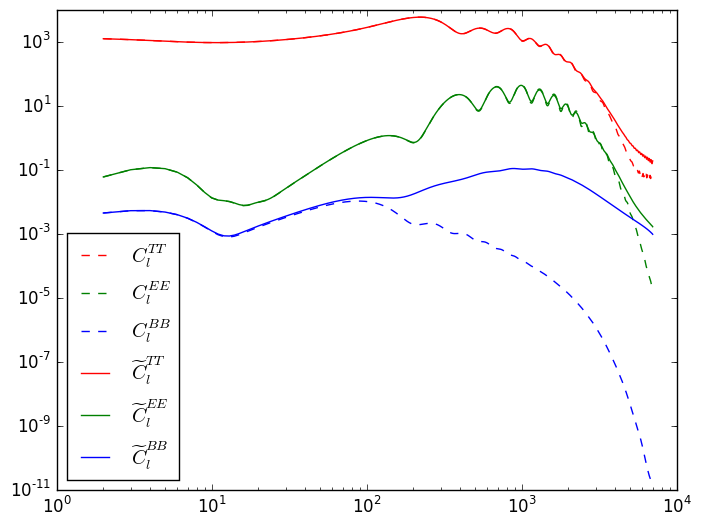

PyObject <matplotlib.legend.Legend object at 0x1182c8d50>

In [30]:

loglog(cls["ell"] .* (cls["ell"] + 1) .* cls["tt"] / 2π, "r--", label = L"C_l^{TT}")
loglog(cls["ell"] .* (cls["ell"] + 1) .* cls["ee"] / 2π, "g--", label = L"C_l^{EE}")
loglog(cls["ell"] .* (cls["ell"] + 1) .* cls["bb"] / 2π, "b--", label = L"C_l^{BB}")

loglog(cls_ln["ell"] .* (cls_ln["ell"] + 1) .* cls_ln["tt"] / 2π, "r-", label = L"\widetilde C_l^{TT}")
loglog(cls_ln["ell"] .* (cls_ln["ell"] + 1) .* cls_ln["ee"] / 2π, "g-", label = L"\widetilde C_l^{EE}")
loglog(cls_ln["ell"] .* (cls_ln["ell"] + 1) .* cls_ln["bb"] / 2π, "b-", label = L"\widetilde C_l^{BB}")
legend(loc = "best")


# Make the spectral matrices

In [31]:
const cEE, cBB, cPh, cPs, cNT, cNE = let
	sig    = (beamFWHM * (π / (180 * 60))) / (2 * √(2 * log(2)))
	beam   = exp(- (sig ^ 2) * (magk .^ 2) / 2)
	beamSQ = abs2(beam)
	
	cNT    = nugget_at_each_pixel * dx ./ beamSQ
	cNE    = √(2) * nugget_at_each_pixel * dx ./ beamSQ
	
	index  = ceil(magk)
	index[find(index.==0)] = 1
	
	logCPh = linear_interp1(cls["ell"], log(cls["pp"]), index)
	logCPh[find(logCPh .== 0)]  = -Inf
	logCPh[find(isnan(logCPh))] = -Inf
	cPh = exp(logCPh)
	
	logCPs = linear_interp1(cls["ell"], log(cls["ps"]), index)
	logCPs[find(logCPs .== 0)]  = -Inf
	logCPs[find(isnan(logCPs))] = -Inf
	cPs = exp(logCPs)
	
	logCBB = linear_interp1(cls["ell"],log(cls["bb"]), index)
	logCBB[find(logCBB .== 0)]  = -Inf 
	logCBB[find(isnan(logCBB))] = -Inf
	cBB = exp(logCBB);
	
	logCEE = linear_interp1(cls["ell"],log(cls["ee"]), index)
	logCEE[find(logCEE .== 0)]  = -Inf  
	logCEE[find(isnan(logCEE))] = -Inf
	cEE = exp(logCEE)

	cEE, cBB, cPh, cPs, cNT, cNE
end

(
1024x1024 Array{Float64,2}:
 0.0          0.000131605  0.000266243  …  0.000266243  0.000131605
 0.000131605  0.000172155  0.000302999     0.000302999  0.000172155
 0.000266243  0.000302999  0.000382773     0.000382773  0.000302999
 0.000405861  0.000421764  0.000464984     0.000464984  0.000421764
 0.000487818  0.000491623  0.000499676     0.000499676  0.000491623
 0.000492946  0.000489547  0.000475659  …  0.000475659  0.000489547
 0.000429091  0.000420261  0.00039665      0.00039665   0.000420261
 0.00032265   0.000311587  0.000289426     0.000289426  0.000311587
 0.000210012  0.000200325  0.000186376     0.000186376  0.000200325
 0.000127367  0.000122156  0.000115369     0.000115369  0.000122156
 0.000102101  0.000102614  0.000106283  …  0.000106283  0.000102614
 0.00015106   0.00015106   0.000163693     0.000163693  0.00015106 
 0.000265657  0.000272506  0.000286522     0.000286522  0.000272506
 ⋮                                      ⋱                          
 0.000265657  0.00

# Simulate unlensed CMB and lensing potentials

In [32]:
# simulate unlensed CMB
E    =  √(cEE) .* fft2(randn(size(x))./ √(dx)) 
B    =  √(cBB) .* fft2(randn(size(x))./ √(dx)) 
Q    = - E .* cos(φ2_l) + B .* sin(φ2_l)
U    = - E .* sin(φ2_l) - B .* cos(φ2_l)
unlensedQUdata = QUandFriends(Q, U)

QUandFriends(1024x1024 Array{Float64,2}:
  1.93787    2.63303    2.49992    …  -2.72346  -1.02175     0.626196 
  0.612443   1.60488    1.68717       -4.7018   -2.91917    -1.02234  
 -0.818855   0.536971   0.90972       -6.79281  -4.97082    -2.82098  
 -1.82031   -0.135142   0.495828      -8.35627  -6.52153    -4.15437  
 -2.07927   -0.166847   0.624117      -8.99564  -7.16324    -4.64866  
 -1.58074    0.434506   1.27158    …  -8.6654   -6.84242    -4.26457  
 -0.605284   1.39758    2.18893       -7.66609  -5.85088    -3.28716  
  0.360536   2.26567    2.96114       -6.5132   -4.71231    -2.2263   
  0.891667   2.65239    3.24345       -5.64577  -3.8939     -1.53828  
  0.898294   2.49909    3.00462       -5.18197  -3.52647    -1.34018  
  0.641473   2.07936    2.51948    …  -4.92256  -3.38759    -1.38845  
  0.473027   1.73606    2.10366       -4.57428  -3.14996    -1.33662  
  0.522101   1.58131    1.84259       -4.00014  -2.67346    -1.04708  
  ⋮                                ⋱

In [33]:
# simulation lensing potentials
ϕ    =  √(cPh) .* fft2(randn(size(x))./ √(dx)) 
ψ    =  √(cPs) .* fft2(randn(size(x))./ √(dx)) 

# convert to  displacements
displx   = ifft2r(im .* k1 .* ϕ) + ifft2r(im .* k2 .* ψ)
disply   = ifft2r(im .* k2 .* ϕ) - ifft2r(im .* k1 .* ψ)

1024x1024 Array{Float64,2}:
 -0.000203685  -0.000190853  -0.00016107   …  -0.000208948  -0.000206084
 -0.000209905  -0.000192654  -0.000171112     -0.000213372  -0.000213245
 -0.000202139  -0.000195779  -0.000187192     -0.000198472  -0.000199636
 -0.000178456  -0.000186847  -0.000188229     -0.000185038  -0.000175794
 -0.000172425  -0.000175822  -0.000180577     -0.000185309  -0.000177032
 -0.000189027  -0.000175619  -0.00017136   …  -0.000205786  -0.000200054
 -0.000210178  -0.000198079  -0.000188781     -0.000228817  -0.000224005
 -0.000232589  -0.000218104  -0.000207891     -0.000241889  -0.000242193
 -0.000212547  -0.000215892  -0.00022195      -0.000235002  -0.000217954
 -0.000206239  -0.000224033  -0.000245525     -0.000233755  -0.000211169
 -0.00023616   -0.000242931  -0.000260205  …  -0.000257008  -0.000242401
 -0.000267783  -0.000264218  -0.000265666     -0.000295486  -0.000278966
 -0.00028048   -0.000276604  -0.000272503     -0.000323889  -0.000296817
  ⋮                    

## First decompose the lensing displacements

In [34]:
indexwrap(ind::Int64, uplim)  = mod(ind - 1, uplim) + 1

function decomplense!(indcol, indrow, rdisplx, rdisply, x, y, displx, disply, deltx)
	# the arguments (indcol, indrow, rdisplx, rdisply) are mutated
	row, col = size(x) 
	period = maximum(x)
	for j = 1:col, i = 1:row
		@inbounds indcol[i,j]  = indexwrap(j + round(Int64, displx[i,j]/deltx), col)
		@inbounds indrow[i,j]  = indexwrap(i + round(Int64, disply[i,j]/deltx), row)
		rdisplx[i,j] = displx[i,j] - deltx * round(Int64, displx[i,j]/deltx)
		rdisply[i,j] = disply[i,j] - deltx * round(Int64, disply[i,j]/deltx)
	end
	return nothing
end
row, col = size(x)
rdisplx  = Array(Float64, row, col)
rdisply  = Array(Float64, row, col)
indcol   = Array(Int64, row, col)
indrow   = Array(Int64, row, col)
decomplense!(indcol, indrow, rdisplx, rdisply, x, y, displx, disply, deltx)

# This shows a slice of the displacements

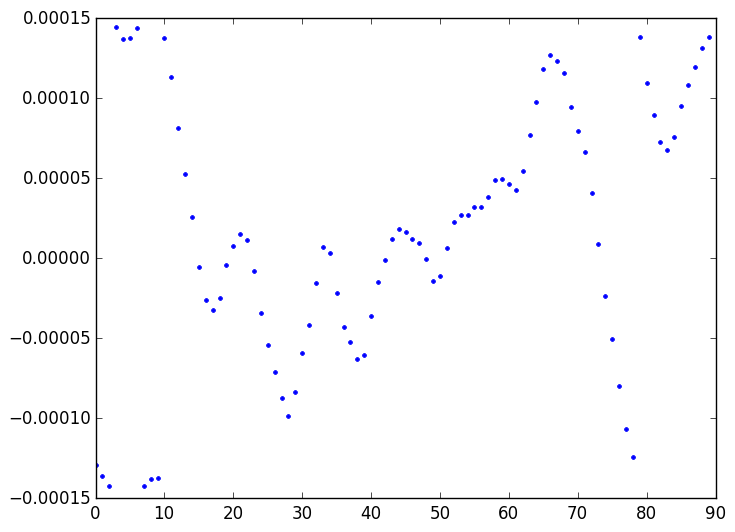

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x114db6a10>

In [35]:
plot(circshift(rdisplx[:,300],0)[1:90],".")

# Now lense

In [36]:
function gridlense!(lF1ₓ, F1ₓ, indcol, indrow)
	# mutates: lF1ₓ
	row, col = size(F1ₓ)
	for j = 1:col
		for i = 1:row
			lF1ₓ[i,j]  = F1ₓ[indrow[i,j], indcol[i,j]]
		end
	end
	return nothing
end
function gridlense!(lF1ₓ, lF2ₓ, F1ₓ, F2ₓ, indcol, indrow)
	# mutates: lF1ₓ, lF2ₓ
	row, col = size(F1ₓ)
	for j = 1:col
		for i = 1:row
			lF1ₓ[i,j]  = F1ₓ[indrow[i,j], indcol[i,j]]
			lF2ₓ[i,j]  = F2ₓ[indrow[i,j], indcol[i,j]]
		end
	end
	return nothing
end

gridlense! (generic function with 2 methods)

In [37]:
# do the integer lensing
lQUdata = gridlense(unlensedQUdata, indcol, indrow)

QUandFriends(1024x1024 Array{Float64,2}:
  2.69188     3.23994    3.23994    …  -1.45712   0.139624    1.59028 
  1.93787     2.63303    2.49992       -2.72346  -1.02175     0.626196
  0.612443    1.60488    1.68717       -4.7018   -2.91917    -1.02234 
 -0.818855    0.536971   0.90972       -6.79281  -4.97082    -2.82098 
 -1.82031    -0.135142   0.495828      -8.35627  -6.52153    -4.15437 
 -2.07927    -0.166847   0.624117   …  -8.99564  -7.16324    -4.64866 
 -1.58074     0.434506   1.27158       -8.6654   -6.84242    -4.26457 
 -0.605284    1.39758    2.18893       -7.66609  -5.85088    -3.28716 
  0.360536    2.26567    2.96114       -6.5132   -4.71231    -2.2263  
  0.891667    2.65239    3.24345       -5.64577  -3.8939     -1.53828 
  0.898294    2.49909    3.00462    …  -5.18197  -3.52647    -1.34018 
  0.641473    2.07936    2.51948       -4.92256  -3.38759    -1.38845 
  0.473027    1.73606    1.73606       -4.57428  -3.14996    -1.33662 
  ⋮                                 

In [38]:
# do the taylor expansion lensing and put everything in a QU object
tldQx  = lQUdata.Qx 
tldQx += (lQUdata.∂1Qx .* rdisplx) 
tldQx += (lQUdata.∂2Qx .* rdisply)
tldQx += 0.5 * (rdisplx .* lQUdata.∂11Qx .* rdisplx ) 
tldQx +=       (rdisplx .* lQUdata.∂12Qx .* rdisply ) 
tldQx += 0.5 * (rdisply .* lQUdata.∂22Qx .* rdisply ) 

tldUx  = lQUdata.Ux 
tldUx += (lQUdata.∂1Ux .* rdisplx) 
tldUx += (lQUdata.∂2Ux .* rdisply)
tldUx += 0.5 * (rdisplx .* lQUdata.∂11Ux .* rdisplx ) 
tldUx +=       (rdisplx .* lQUdata.∂12Ux .* rdisply ) 
tldUx += 0.5 * (rdisply .* lQUdata.∂22Ux .* rdisply ) 

tldQUdata = QUandFriends(tldQx, tldUx)

# convert to E, B
Ex    = - fft2(unlensedQUdata.Qx)    .* cos(φ2_l) - fft2(unlensedQUdata.Ux)    .* sin(φ2_l)  |> ifft2r
Bx    =   fft2(unlensedQUdata.Qx)    .* sin(φ2_l) - fft2(unlensedQUdata.Ux)    .* cos(φ2_l)  |> ifft2r
lEx   = - fft2(lQUdata.Qx)   .* cos(φ2_l) - fft2(lQUdata.Ux)   .* sin(φ2_l) |> ifft2r
lBx   =   fft2(lQUdata.Qx)   .* sin(φ2_l) - fft2(lQUdata.Ux)   .* cos(φ2_l) |> ifft2r
tldEx = - fft2(tldQUdata.Qx) .* cos(φ2_l) - fft2(tldQUdata.Ux) .* sin(φ2_l) |> ifft2r
tldBx =   fft2(tldQUdata.Qx) .* sin(φ2_l) - fft2(tldQUdata.Ux) .* cos(φ2_l) |> ifft2r

1024x1024 Array{Float64,2}:
 -0.062815    0.0887724   0.101663   …  -0.328104   -0.2805     -0.185421  
  0.020561    0.153246    0.165535      -0.11642    -0.117429   -0.102575  
  0.0933614   0.160452    0.248731       0.128409    0.124459    0.0809032 
  0.226129    0.246182    0.256412       0.183163    0.168319    0.21103   
  0.272029    0.337411    0.26415        0.106136    0.0491206   0.127926  
  0.282211    0.401916    0.212792   …   0.0567564  -0.0227035   0.0454444 
  0.36936     0.477705    0.304615       0.0807323  -0.0277778   0.0699272 
  0.501259    0.535019    0.335903       0.0628829   0.0492194   0.233979  
  0.539321    0.473133    0.246829      -0.0349026   0.0650666   0.357902  
  0.593594    0.427916    0.258043      -0.117436    0.112965    0.452638  
  0.621321    0.500499    0.342904   …  -0.0541777   0.205923    0.485029  
  0.643348    0.551436    0.388174       0.0156343   0.240082    0.51131   
  0.626397    0.5372      0.355995       0.0521887   0.16940

Here are some tests for speed

In [39]:
#=
indcol, indrow   = Array(Int, size(x)), Array(Int, size(x))
rdisplx, rdisply = Array(Float64, size(x)), Array(Float64, size(x))
gc()
@time  decomplense!(indcol, indrow, rdisplx, rdisply, x, y, displx, disply, deltx);

glenQx = Array(Float64, size(x))
gc()
@time gridlense!(glenQx, Qx, indcol, indrow);

using ProfileView
@profileview gridlense!(glenQx, Qx, indcol, indrow);

g = @code_typed gridlense!(glenQx, Qx, indcol, indrow);
g[1].args[2][2]

g = @code_typed decomplense!(indcol, indrow, rdisplx, rdisply, x, y, displx, disply, deltx)
g[1].args[2][2]
=#

# This shows the difference between unlensed B, integer lensed B and integer + 2nd taylor lensed B

In [40]:
#=
figure(figsize = (12, 3))
subplot(1,3,1)
imshow(Bx[1:100,1:100]); title("unlensed B"); clim(-1.8, 1.8); colorbar(); 
subplot(1,3,2)
imshow(lBx[1:100,1:100]); title("int lensed B"); clim(-1.8, 1.8); colorbar(); 
subplot(1,3,3)
imshow(tldBx[1:100,1:100]); title("int+taylor lensed B"); clim(-1.8, 1.8); colorbar(); 
=#

## Lets check that the spectral density of lensed B looks right

In [41]:
#=
tldB = fft2(tldBx)
lB = fft2(lBx)
B = fft2(Bx)

loglog(cls["ell"], cls_ln["ell"] .* (cls_ln["ell"] + 1) .* cls_ln["ee"] / (2π), "g-", label = L"\widetilde C_l^{EE}")
loglog(cls["ell"], cls_ln["ell"] .* (cls_ln["ell"] + 1) .* cls_ln["bb"] / (2π), "b-", label = L"\widetilde C_l^{BB}")
loglog(cls["ell"], cls["ell"] .* (cls["ell"] + 1) .* cls["bb"] / (2π), "b--", label = L"C_l^{BB}")
loglog(cls["ell"], cls["ell"] .* (cls["ell"] + 1) .* cls["bb"] / (2π), "b--", label = L"C_l^{BB}")

function binave(fk::Matrix, kmag::Matrix, bin_mids::Range)
fpwr = Array(Complex{Float64}, length(bin_mids))
fill!(fpwr, -1.0)
rtcuts  = collect(bin_mids +  step(bin_mids) / 2)  
lftcuts = collect(bin_mids -  step(bin_mids) / 2)  
	lftcuts[1] = 0.1 # extend the left boundary all the way down, but not zero
	for i in 1:length(bin_mids)
		ibin = lftcuts[i] .<= kmag .< rtcuts[i]
		fpwr[i] = fk[ibin] |> mean   
	end
	fpwr
end
loglog(110:100:9000, binave(magk .* (magk + 1) .* abs2(tldB*deltk) / (2π), magk, 110:100:9000), ".", label = L"tldB")
loglog(110:100:9000, binave(magk .* (magk + 1) .* abs2(lB*deltk)   / (2π), magk, 110:100:9000), ".", label = L"lB")
loglog(110:100:9000, binave(magk .* (magk + 1) .* abs2(B*deltk)    / (2π), magk, 110:100:9000), ".", label = L"B")
legend(loc = "best")

=#

# Gradient updates

In [42]:
# make the M weights
# this should eventually be pushed to a module or hardwired into the grad calculations
const Mq  = squash!(-1 * cos(φ2_l).^2 ./ cEE / 2 - sin(φ2_l).^2 ./ cBB / 2) 
const Mu  = squash!(-1 * cos(φ2_l).^2 ./ cBB / 2 - sin(φ2_l).^2 ./ cEE / 2)
const Mqu = squash!(-1 * cos(φ2_l) .* sin(φ2_l) .* (cBB - cEE) ./ cBB ./ cEE)

Mq[magk .>= maskupC]  = 0.0 
Mu[magk .>= maskupC]  = 0.0 
Mqu[magk .>= maskupC] = 0.0 

ϕcurr = zero(ϕ)
ψcurr = zero(ψ)

1024x1024 Array{Complex{Float64},2}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
    ⋮                             ⋱                               

In [49]:
@time gradupdate!(ϕcurr, ψcurr, tldQUdata, 4000, 2e-6)

-0.5 * sum(squash!(abs2(Eϕψ .* (magk .<= maskupC)) ./ cEE)) * dk => -14467.557134035123
-0.5 * sum(squash!(abs2(Bϕψ .* (magk .<= maskupC)) ./ cBB)) * dk => -9332.182877230238
loglike => -40427.54953361035
 
-0.5 * sum(squash!(abs2(Eϕψ .* (magk .<= maskupC)) ./ cEE)) * dk => -14467.56284793501
-0.5 * sum(squash!(abs2(Bϕψ .* (magk .<= maskupC)) ./ cBB)) * dk => -9318.407192920236
loglike => -40414.960451729494
 
-0.5 * sum(squash!(abs2(Eϕψ .* (magk .<= maskupC)) ./ cEE)) * dk => -14467.550974268375
-0.5 * sum(squash!(abs2(Bϕψ .* (magk .<= maskupC)) ./ cBB)) * dk => -9310.37923361851
loglike => -40408.101269993494
 
-0.5 * sum(squash!(abs2(Eϕψ .* (magk .<= maskupC)) ./ cEE)) * dk => -14467.530394033529
-0.5 * sum(squash!(abs2(Bϕψ .* (magk .<= maskupC)) ./ cBB)) * dk => -9298.216669613552
loglike => -40397.07974267118
 
-0.5 * sum(squash!(abs2(Eϕψ .* (magk .<= maskupC)) ./ cEE)) * dk => -14467.54877609304
-0.5 * sum(squash!(abs2(Bϕψ .* (magk .<= maskupC)) ./ cBB)) * dk => -9287.26833926595

# images, normalized to see the structure of the updates when small

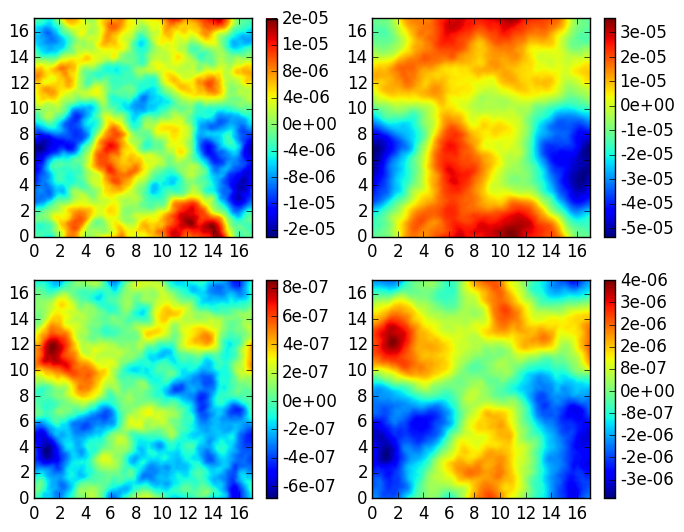

PyObject <matplotlib.colorbar.Colorbar instance at 0x122de4fc8>

In [44]:


subplot(2,2,2)
	ϕₓ = ifft2r(ϕ)
	imshow(
		ϕₓ, 
  		interpolation = "nearest", 
  		origin="lower", 
  		extent=(180/π)*[minimum(x), maximum(x),minimum(x), maximum(x)]
	) 
	colorbar(format="%.e")
subplot(2,2,1)
	ϕcurrₓ = ifft2r(ϕcurr)
	imshow(
		ϕcurrₓ, 
  		interpolation = "nearest", 
  		origin="lower", 
  		extent=(180/π)*[minimum(x), maximum(x),minimum(x), maximum(x)]
	) 
	colorbar(format="%.e")
subplot(2,2,4)
	ψₓ = ifft2r(ψ)
	imshow(
		ψₓ, 
  		interpolation = "nearest",
  		origin="lower", 
  		extent=(180/π)*[minimum(x), maximum(x),minimum(x), maximum(x)]
	) 
	colorbar(format="%.e")
subplot(2,2,3)
	ψcurrₓ = ifft2r(ψcurr)
	imshow(
		ψcurrₓ, 
  		interpolation = "nearest", 
  		origin="lower", 
  		extent=(180/π)*[minimum(x), maximum(x),minimum(x), maximum(x)]
	) 
	colorbar(format="%.e")



# images, un-normalized

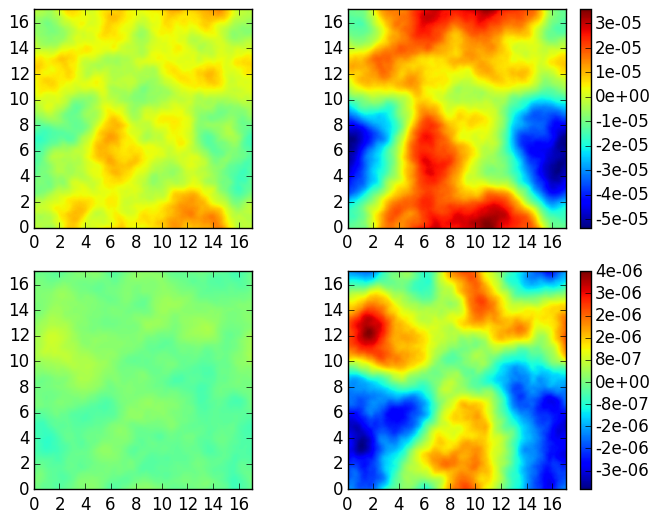

PyObject <matplotlib.image.AxesImage object at 0x12b6c10d0>

In [45]:


subplot(2,2,2)
	ϕₓ = ifft2r(ϕ)
	imshow(
		ϕₓ, 
  		interpolation = "nearest", 
  		vmin=minimum(ϕₓ),
  		vmax=maximum(ϕₓ), 
  		origin="lower", 
  		extent=(180/π)*[minimum(x), maximum(x),minimum(x), maximum(x)]
	) 
	colorbar(format="%.e")
subplot(2,2,1)
	ϕcurrₓ = ifft2r(ϕcurr)
	imshow(
		ϕcurrₓ, 
  		interpolation = "nearest", 
  		vmin=minimum(ϕₓ),
  		vmax=maximum(ϕₓ), 
  		origin="lower", 
  		extent=(180/π)*[minimum(x), maximum(x),minimum(x), maximum(x)]
	) 
subplot(2,2,4)
	ψₓ = ifft2r(ψ)
	imshow(
		ψₓ, 
  		interpolation = "nearest", 
  		vmin=minimum(ψₓ),
  		vmax=maximum(ψₓ), 
  		origin="lower", 
  		extent=(180/π)*[minimum(x), maximum(x),minimum(x), maximum(x)]
	) 
	colorbar(format="%.e")
subplot(2,2,3)
	ψcurrₓ = ifft2r(ψcurr)
	imshow(
		ψcurrₓ, 
  		interpolation = "nearest", 
  		vmin=minimum(ψₓ),
  		vmax=maximum(ψₓ), 
  		origin="lower", 
  		extent=(180/π)*[minimum(x), maximum(x),minimum(x), maximum(x)]
	) 



## Lets check the delensed spectral density of lensed B

/Users/ethananderes/Software/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


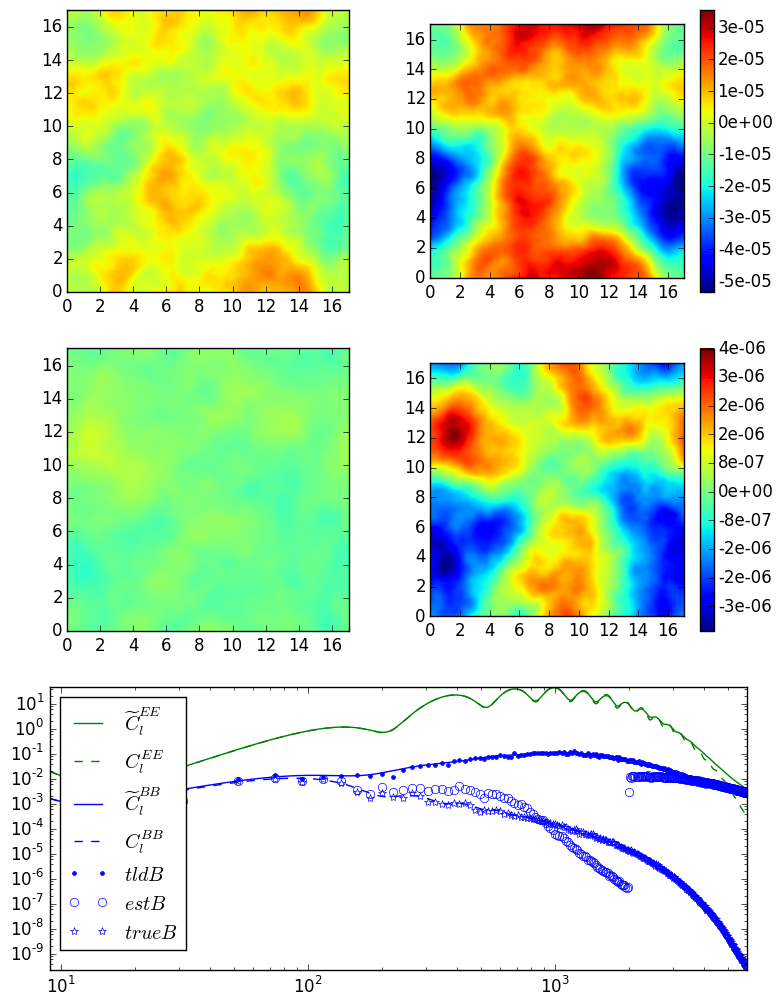

PyObject <matplotlib.legend.Legend object at 0x18c109350>

/Users/ethananderes/Software/anaconda/lib/python2.7/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


In [46]:
figure(figsize = (9,12))
subplot2grid((3,2), (0,1), colspan=1)
	ϕₓ = ifft2r(ϕ)
	imshow(
		ϕₓ, 
  		interpolation = "nearest", 
  		vmin=minimum(ϕₓ),
  		vmax=maximum(ϕₓ), 
  		origin="lower", 
  		extent=(180/π)*[minimum(x), maximum(x),minimum(x), maximum(x)]
	) 
	colorbar(format="%.e")
subplot2grid((3,2), (0,0), colspan=1)
	ϕcurrₓ = ifft2r(ϕcurr)
	imshow(
		ϕcurrₓ, 
  		interpolation = "nearest", 
  		vmin=minimum(ϕₓ),
  		vmax=maximum(ϕₓ), 
  		origin="lower", 
  		extent=(180/π)*[minimum(x), maximum(x),minimum(x), maximum(x)]
	) 
subplot2grid((3,2), (1,1), colspan=1)
	ψₓ = ifft2r(ψ)
	imshow(
		ψₓ, 
  		interpolation = "nearest", 
  		vmin=minimum(ψₓ),
  		vmax=maximum(ψₓ), 
  		origin="lower", 
  		extent=(180/π)*[minimum(x), maximum(x),minimum(x), maximum(x)]
	) 
	colorbar(format="%.e")
subplot2grid((3,2), (1,0), colspan=1)
	ψcurrₓ = ifft2r(ψcurr)
	imshow(
		ψcurrₓ, 
  		interpolation = "nearest", 
  		vmin=minimum(ψₓ),
  		vmax=maximum(ψₓ), 
  		origin="lower", 
  		extent=(180/π)*[minimum(x), maximum(x),minimum(x), maximum(x)]
	) 
subplot2grid((3,2), (2,0), colspan=2)
Qϕψx, Uϕψx, ∂1Qϕψx, ∂1Uϕψx, ∂2Qϕψx, ∂2Uϕψx    = easylense(tldQUdata, -ϕcurr, -ψcurr) 
est_E   = - fft2(Qϕψx) .* cos(φ2_l) - fft2(Uϕψx) .* sin(φ2_l) 
est_B   =   fft2(Qϕψx) .* sin(φ2_l) - fft2(Uϕψx) .* cos(φ2_l) 
tldB    =   fft2(tldBx)
uplim = 6000
llim = 10
loglog(cls["ell"][llim:uplim], cls["ell"][llim:uplim] .* (cls["ell"][llim:uplim] + 1) .* cls_ln["ee"][llim:uplim]  / (2π), "g-", label = L"\widetilde C_l^{EE}")
loglog(cls["ell"][llim:uplim], cls["ell"][llim:uplim] .* (cls["ell"][llim:uplim] + 1) .* cls["ee"][llim:uplim]  / (2π), "g--", label = L" C_l^{EE}")
loglog(cls["ell"][llim:uplim], cls["ell"][llim:uplim] .* (cls["ell"][llim:uplim] + 1) .* cls_ln["bb"][llim:uplim]  / (2π), "b-", label = L"\widetilde C_l^{BB}")
loglog(cls["ell"][llim:uplim], cls["ell"][llim:uplim] .* (cls["ell"][llim:uplim] + 1) .* cls["bb"][llim:uplim]  / (2π), "b--", label = L"C_l^{BB}")
function binave(fk::Matrix, kmag::Matrix, bin_mids::Range)
	fpwr = Array(Complex{Float64}, length(bin_mids))
	fill!(fpwr, -1.0)
	rtcuts  = collect(bin_mids +  step(bin_mids) / 2)  
	lftcuts = collect(bin_mids -  step(bin_mids) / 2)  
		lftcuts[1] = 0.1 # extend the left boundary all the way down, but not zero
		for i in 1:length(bin_mids)
			ibin = lftcuts[i] .<= kmag .< rtcuts[i]
			fpwr[i] = fk[ibin] |> mean   
		end
	fpwr
end
loglog(llim:deltk:uplim, binave(magk .* (magk + 1) .* abs2(tldB*deltk) / (2π), magk, llim:deltk:uplim), "b.", label = L"tldB")
loglog(llim:deltk:uplim, binave(magk .* (magk + 1) .* abs2(est_B*deltk) /(2π), magk, llim:deltk:uplim), "o", markeredgecolor = "blue",  mfc="none", label = L"est B")
loglog(llim:deltk:uplim, binave(magk .* (magk + 1) .* abs2(B*deltk) /(2π), magk, llim:deltk:uplim), "*", markeredgecolor = "blue",  mfc="none", label = L"true B")
axis("tight")
legend(loc = "best")

# This shows the difference between estimated B, true primordial B

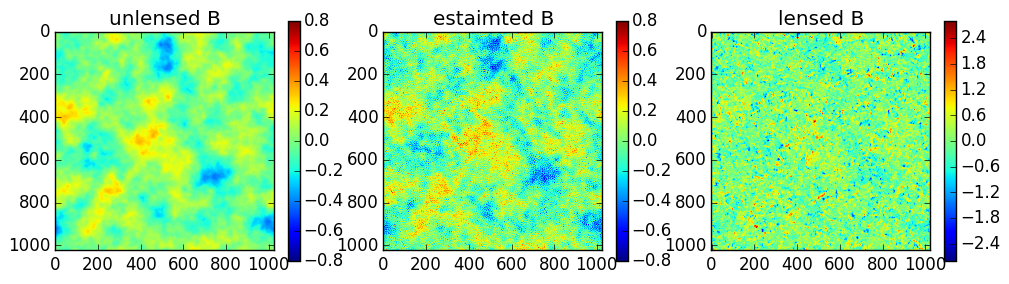

In [47]:


figure(figsize = (12, 3))
subplot(1,3,1)
imshow(Bx); title("unlensed B"); clim(-0.8, 0.8); colorbar(); 
subplot(1,3,2)
imshow(ifft2r(est_B)); title("estaimted B"); clim(-0.8, 0.8); colorbar(); 
subplot(1,3,3)
imshow(tldBx); title("lensed B"); clim(-2.8, 2.8); colorbar(); 



# Lets look at the spectral power of the lensing estimates

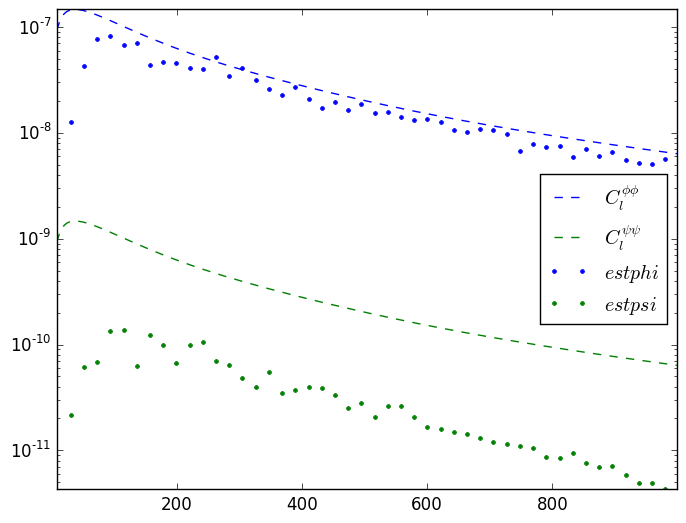

PyObject <matplotlib.legend.Legend object at 0x122e22590>

In [48]:
uplim = 1000
llim = 10

semilogy(cls["ell"][llim:uplim], (cls["ell"][llim:uplim].^4) .* cls["pp"][llim:uplim]  / (2π), "b--", label = L"C_l^{\phi\phi}")
semilogy(cls["ell"][llim:uplim], (cls["ell"][llim:uplim].^4) .* cls["ps"][llim:uplim]  / (2π), "g--", label = L"C_l^{\psi\psi}")
function binave(fk::Matrix, kmag::Matrix, bin_mids::Range)
	fpwr = Array(Complex{Float64}, length(bin_mids))
	fill!(fpwr, -1.0)
	rtcuts  = collect(bin_mids +  step(bin_mids) / 2)  
	lftcuts = collect(bin_mids -  step(bin_mids) / 2)  
		lftcuts[1] = 0.1 # extend the left boundary all the way down, but not zero
		for i in 1:length(bin_mids)
			ibin = lftcuts[i] .<= kmag .< rtcuts[i]
			fpwr[i] = fk[ibin] |> mean   
		end
	fpwr
end
semilogy(llim:deltk:uplim, binave((magk.^4) .* abs2(ϕcurr*deltk) / (2π), magk, llim:deltk:uplim), "b.", label = L"est phi")
semilogy(llim:deltk:uplim, binave((magk.^4) .* abs2(ψcurr*deltk) / (2π), magk, llim:deltk:uplim), "g.", label = L"est psi")
axis("tight")
legend(loc = "best")